<a href="https://colab.research.google.com/github/K-Chorna02/DST_Assessment_2/blob/main/Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal statement here
To discuss:
- Scaling performance in terms of data volume and resource allocated

- Parallelism via GPUs

- Comparison between parallel and single-machine problems



• additional implementation if an oﬀ-the-shelf implementation falls
short,
• exploring multiple implementations,
• examining the mathematical details of choices.
identifying an appropriate dataset;
• using your understanding of the structure of datasets to make ar-
guments comparing the dataset you chose to one that you might
encounter in a “real” data-science setting;
• plotting or otherwise describing various inputs, outputs, or parame-
ters.
(c) the correctness of the methods used to achieve their stated goals.
(d) the robustness of the results in supporting the conclusions.




# Introduction


To include in intro: Clearly outline our goal (choose an appropriate scientific/analysis question) , discuss our goal in more detail here, mention how we would scale to a deployable data-science solution.


We focus on Image classification using Convolutional Neural Networks. Our goal is to investigate how different optimisation strategies and model architectures affect classification accuracy and robustness, and to determine which methods generalise best when scaled to more complex and realistic datasets.

We will talk through the following steps :
Focusing on a toy dataset (CIFAR-10) where we discuss optimisation approaches, before generalising to a more realistic dataset (Food 101) where we create pre-trained models from scratch (ResNet18 and Transorm ).
Finally, we test their robustness using adversarial attack .

Mention: Why we've chosen this



In [2]:
#Loading necessary libraries
import torch #creates/trains models and performs tensor operations
import torchvision #gives popular datasets, model architectures and image processing stuff
import torchvision.transforms as transforms #helps preprocess images to help model use them
import matplotlib.pyplot as plt #for plotting
import numpy as np
import random
from torchvision import datasets, transforms
from torch.utils.data import Subset


## About our datasets
### CIFAR-10

CIFAR-10 dataset can be found online at: https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

This is a widely used benchmark dataset created by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton, used for image classification in machine learning methods.

It consists of 60,000 sets of 32x32 images split into 10 classes, such as planes, cars, birds, cats, etc. Of these 50,000 are sued for training and the remaining 10,000 are used for testing.
This makes it a perfect starting point for our project, serving as a toy dataset to better understand neural networks. Due to its low resolution, we are able to explore the impacts of different hyperparameters and hence optimize our neural network.


By experimenting and exploring the effects of different optimization approaches on CIFAR-10, we aim to understand which approaches generalise well before applying them to larger and more complex datasets.
We note some may improve performance specifically on this data set but not generalise so well.

Below we load CIFAR-10:




In [3]:
batch_size = 10 #we can vary the batch size, but this basically shows that ...

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]) # discuss transforms

In [8]:
print("Downloading training data...")
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

print("Downloading testing data...")
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

#info
print(f"Training samples: {len(trainset)}")
print(f"Testing samples: {len(testset)}")
print(f"Classes: {trainset.classes}")


Training samples: 50000
Testing samples: 10000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


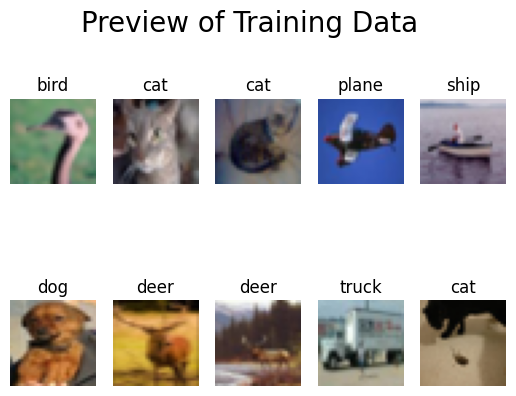

In [9]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

dataiter = iter(trainloader)
images, labels = next(dataiter) #slight modification here to account for python update

for i in range(batch_size):
    plt.subplot(2, int(batch_size/2), i + 1) #creates subplots
    img = images[i] #extracts each image
    img = img / 2 + 0.5 #undoes normalisation to restore original colour range
    npimg = img.numpy() #convert tensor to numpy array so we can plot with matplotlib
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #adjusts image dimensions (SEE CELL BELOW)
    plt.axis('off')
    plt.title(classes[labels[i]]) #labels subplots

plt.suptitle('Preview of Training Data', size=20)
plt.show()

Why CIFAR-10 helps you explore these?
How it fits into your project goals?

### Food 101
The Food 101 dataset is a large scale dataset composed of realistic photos taken of different dishes. The data set was compiled by (@bossard14) who used images from 'foodspotting.com', a site that allows users to take images of what they are eating, annotate place and type of food, and upload the information online, resulting in this open source dataset.
The creators (@bossard14) created this with the aim of using image clasification with different dishes.

Food typically does not exhibit any distinctive spatial layout, unlike images in the CIFAR-10 dataset where an image with a plane often follows expected visual compositions of the sky in the background.
The images themselves are taken from different angles, different lightings, viewpoints and background context.
For this reason we felt this dataset reflected the complexities of real life scenarios.

This dataset consists of 101 food categories, with 101, 000 images. For each class, 250 manually cleaned test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.


This dataset demonstrates a more realistic progression beyond CIFAR-10, allowing us to investigate deeper architectural choices, such as ResNet-18 and ViTs, before comparing model performance under imperfect, real-world conditions.

The data is split in the following way:
- Train: 75,750
- Test: 25,250

Below we import the dataset to get an overview :



In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"


# Loading Food-101 dataset
# Defining the original dataset
food_root = "data"
train_dataset = datasets.Food101(root=food_root, split="train", download=True)
test_dataset  = datasets.Food101(root=food_root, split="test",  download=True)

print(f"Full train size: {len(train_dataset)}, test size: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")

100%|██████████| 5.00G/5.00G [18:02<00:00, 4.61MB/s]


Full train size: 75750, test size: 25250
Number of classes: 101


Note: The original resolution is 256x256 but due to our limited GPU resources, we reduced to 64x64 to train our models effectively.

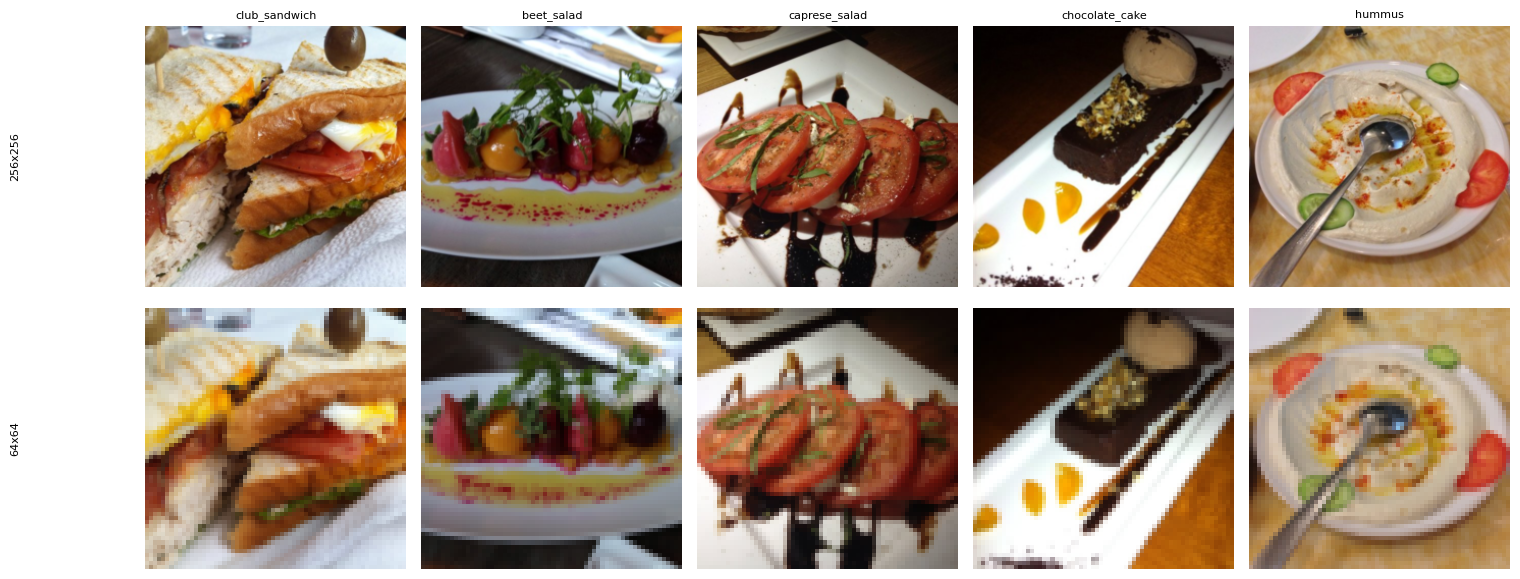

In [7]:
subset_train_idx = random.sample(range(len(train_dataset)), 5)  # pick 5 random images
train_subset = Subset(train_dataset, subset_train_idx)

# Define transforms for different resolutions
resolutions = [256, 64]
transforms_dict = {r: transforms.Compose([transforms.Resize((r,r)), transforms.ToTensor()]) for r in resolutions}

# Plot the same random images at multiple resolutions with labels and size
def plot_same_images_with_labels(dataset, resolutions):
    n = len(dataset)  # number of images in subset
    fig, axs = plt.subplots(len(resolutions), n, figsize=(n*3, len(resolutions)*3))

    for j in range(n):
        img, label_idx = dataset[j]
        label = dataset.dataset.classes[label_idx]  # get class name
        for i, r in enumerate(resolutions):
            img_r = transforms_dict[r](img)  # resize same image
            img_np = img_r.permute(1,2,0).numpy()
            axs[i,j].imshow(img_np)
            axs[i,j].axis('off')
            # show class + resolution above the first row
            if i == 0:
                axs[i,j].set_title(f"{label}", fontsize=8)
            # optional: put resolution inside the first column
            if j == 0:
                axs[i,j].text(-0.5, 0.5, f"{r}x{r}", rotation=90, fontsize=8, va='center', ha='center', transform=axs[i,j].transAxes)
    plt.tight_layout()
    plt.show()

plot_same_images_with_labels(train_subset, resolutions)


## EDA
We carry out exploratory data analysis on both datasets to ...

Note: Justify appropriateness of the datasets

We begin with EDA on CIFAR-10:
(I've shown the class distribution but we're already told that there are 5000 in each so do I need this ?)

In [10]:
# EDA on CIFAR-10:
from collections import Counter
labels = [label for _, label in trainset]
label_counts = Counter(labels)

for idx, count in label_counts.items():
    print(f"{trainset.classes[idx]}: {count}")

frog: 5000
truck: 5000
deer: 5000
automobile: 5000
bird: 5000
horse: 5000
ship: 5000
cat: 5000
dog: 5000
airplane: 5000


In [11]:
print(images.shape) #printing the size of the images- again we know they're 32x32 so do we need to include??

torch.Size([10, 3, 32, 32])


In [12]:
import torch

all_pixels = torch.cat([images.view(-1, 3) for images, _ in trainloader], dim=0)

print(all_pixels.mean(dim=0))  # per-channel mean
print(all_pixels.std(dim=0))   # per-channel std
#Discuss this

tensor([-0.0533, -0.0533, -0.0533])
tensor([0.5031, 0.5031, 0.5032])


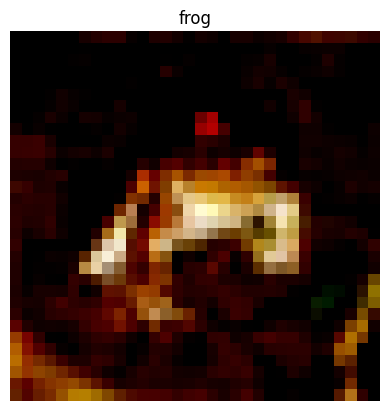

In [13]:
img, label = trainset[0]
plt.imshow(img.permute(1, 2, 0))
plt.title(trainset.classes[label])
plt.axis('off')
plt.show()
#Discuss this

### Literature review

After reviewing (cite ResNet), we concluded that...

## Report

Discuss: appropriate strategy to learn about the computational per-
formance of the models- optimizing and comparing robustness?


Throughout our project we will explore the following:
- Optimization using CIFAR-10, looking at the following:
    - Number of convolutional layers and their impact on model performance
    - Learning rates
    - Optimizers
    - Kernels
    - Max_pool
    - Activation functions
    - Padding
    - And other hyperparameters

-  Creating ResNet18 from Scratch Using PyTorch and comparing to the plain model (cite)
Discuss: Why ResNet?? Why 18 layers ?
Using optimization we found from CIFAR-10


- Creating Transformer model (VIT)
Discuss: Why VIT?


- Using adversarial attack to test model robustness
Using a seperate test set and apply trnsforms such as noise, rotation etc to reflect a real-world scenario.
So here we are applying our models by testing on this set.


Question: Do we reduce the dataset?


# Limitations
- Colab GPU limitations
- Time constraint
- Memory
- Knowledge of Neural Networks


## Optimization using CIFAR-10




Extension: visualising the effct of convolutional layers ?
image explanation of the kernel: https://arxiv.org/pdf/1311.2901

looking at the following:
  - Number of convolutional layers and their impact on model performance
  - Learning rates
  - Optimizers
  - Kernels
  - Max_pool
  - Activation functions
  - Padding
  - And other hyperparameters


Fine tuning? Discuss

## ResNet- 18
ResNet 18 is a pretrained model...
It  uses 18 convolutional layers.
After reading (cite), ...


Transfer learning ? - discuss

Kat use this video - https://www.youtube.com/watch?v=DkNIBBBvcPs

Discuss this paper to justify choice of layers and resnet : ResNet architecture: https://arxiv.org/pdf/1512.03385

## VIT Transformer
A 'state of the art' ....

Vision transformers and ViT architecture: https://arxiv.org/pdf/2010.11929

## Adversarial attack
We use this to evaluate the robustness of our model.
Comparing robustness: https://ieeexplore.ieee.org/document/11098661


Need to create the code to modify the images

# References
@inproceedings{bossard14,
  title = {Food-101 -- Mining Discriminative Components with Random Forests},
  author = {Bossard, Lukas and Guillaumin, Matthieu and Van Gool, Luc},
  booktitle = {European Conference on Computer Vision},
  year = {2014}
}


@ARTICLE{robustness,
  author={Kumar, Vishesh and Shukla, Shivam and Agarwal, Akshay},
  journal={IEEE Transactions on Big Data},
  title={Robustness Benchmarking of Convolutional and Transformer Architectures for Image Classification},
  year={2025},
  volume={11},
  number={6},
  pages={3330-3341},
  keywords={Robustness;Transformers;Image resolution;Image quality;Image classification;Distortion;Computer vision;Image coding;Deep learning;Benchmark testing;Corruption;convolution;transformer;robustness;explainability},
  doi={10.1109/TBDATA.2025.3593385}}
